In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pywt

Preprocessing :
Using wavelet transform as a feature for training our model

In a wavelet transformed image you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips

https://medium.com/@koushikc2000/2d-discrete-wavelet-transformation-and-its-applications-in-digital-image-processing-using-matlab-1f5c68672de3

In [2]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

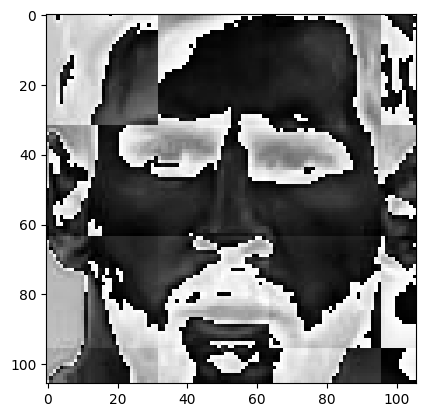

In [6]:
cropped_img = cv2.imread('./dataset/cropped/lionel_messi/lionel_messi11.png')
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [8]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

cropped_image_dirs = ['./dataset/cropped/lionel_messi','./dataset/cropped/maria_sharapova','./dataset/cropped/roger_federer','./dataset/cropped/serena_williams','./dataset/cropped/virat_kohli']

In [9]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi\\lionel_messi1.png',
  './dataset/cropped/lionel_messi\\lionel_messi10.png',
  './dataset/cropped/lionel_messi\\lionel_messi11.png',
  './dataset/cropped/lionel_messi\\lionel_messi13.png',
  './dataset/cropped/lionel_messi\\lionel_messi14.png',
  './dataset/cropped/lionel_messi\\lionel_messi15.png',
  './dataset/cropped/lionel_messi\\lionel_messi16.png',
  './dataset/cropped/lionel_messi\\lionel_messi17.png',
  './dataset/cropped/lionel_messi\\lionel_messi18.png',
  './dataset/cropped/lionel_messi\\lionel_messi19.png',
  './dataset/cropped/lionel_messi\\lionel_messi2.png',
  './dataset/cropped/lionel_messi\\lionel_messi20.png',
  './dataset/cropped/lionel_messi\\lionel_messi22.png',
  './dataset/cropped/lionel_messi\\lionel_messi23.png',
  './dataset/cropped/lionel_messi\\lionel_messi24.png',
  './dataset/cropped/lionel_messi\\lionel_messi25.png',
  './dataset/cropped/lionel_messi\\lionel_messi26.png',
  './dataset/cropped/lionel_messi\

In [10]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [11]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [12]:
len(X[0])

4096

In [13]:
32*32*3 + 32*32

4096

In [14]:
X[0]

array([[100],
       [129],
       [140],
       ...,
       [237],
       [234],
       [232]], dtype=uint8)

In [15]:
y[0]

0

In [16]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(165, 4096)